In [1]:
import cv2
import numpy as np
import os
import glob

import matplotlib.pyplot as plt

from box_io import load_beeframe_meta_from_box
from comb_loading import get_organized_colony_names
from comb_loading import load_colony_comb  
from mask_processing import get_class_contours
from comb_growth import get_perpendicular_growth_at_point

In [3]:
load_meta_from_file = True
if load_meta_from_file:
    meta_file = "/home/golden/Dropbox/bee-comb/img_to_text_df_TOEDIT.csv"
    beeframe_meta = pd.read_csv(meta_file)
else:
    # Only if don't have local copy of "img_to_text_df_TOEDIT.csv"
    # These variable need to be changed to match user
    comb_meta_filename = "img_to_text_df_TOEDIT.csv"
    box_config_file = "/home/golden/kenya_drones/comb-detection/config.json"
    box_user_id = '15809502026'
    meta_folder_id = "133070825445"
    beeframe_meta = load_beeframe_meta_from_box(comb_meta_filename, 
                                               box_config_file,
                                               box_user_id,
                                               meta_folder_id
                                              )

In [4]:
colony_names = get_organized_colony_names(beeframe_meta)

In [5]:
masks_folder_root = "/home/golden/kenya_drones/comb-detection/nest_photos"
colony_name = colony_names[3]
masks_folder_name = "warped_masks"

colony = load_colony_comb(beeframe_meta, colony_name, 
                          masks_folder_root, masks_folder_name,
                          combine_ab=True
                         )
print(f"loaded colony {colony_name}")

loaded colony DD5


Text(0.5, 1.0, 'frame 4 week 3')

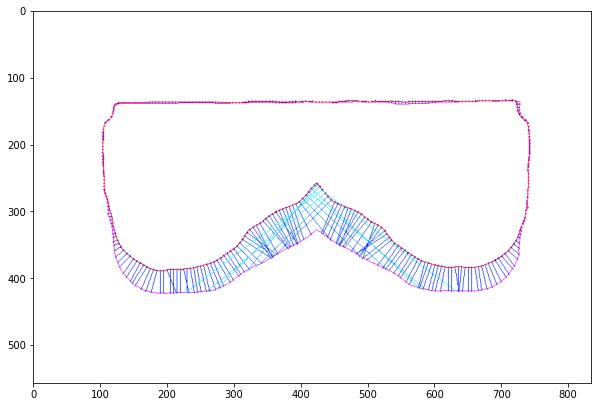

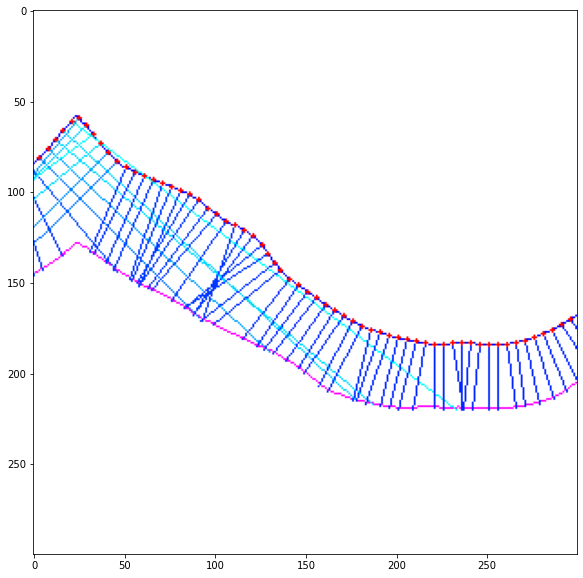

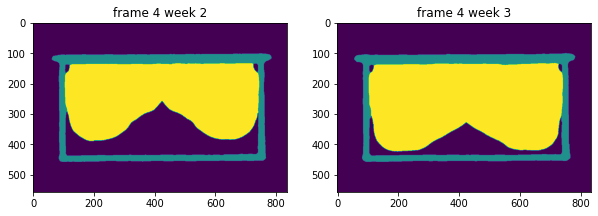

In [6]:
week0 = 2
week1 = 3
frame_num = 4
# comb class label
comb_id = 2 

# How often to draw growth line around contour
line_spacing = 5 
# How many points on each side of contour point to average
# to estimate local tangent
buffer = 3 
#How often to check for comb on growth line (pixels)      
step_size = 5

target = comb_id
background = 0



display = np.ones((colony.shape[2], colony.shape[3], 3), dtype=np.uint8) * 255

mask0 = colony[week0, frame_num]
mask1 = colony[week1, frame_num]
comb_contours0 = get_class_contours(mask0, class_id=comb_id)
comb_contours1 = get_class_contours(mask1, class_id=comb_id)

cv2.drawContours(display, comb_contours0, -1, [0, 0, 255], 1)
cv2.drawContours(display, comb_contours1, -1, [255, 0, 255], 1)


max_distance = 0 
# This look just for seeing max growth distance for setting colors for display
for contour in comb_contours0:
    for ind in range(0, len(contour), line_spacing):
        point, distance = get_perpendicular_growth_at_point(mask0, mask1, contour, 
                                                            ind, step_size, target, 
                                                            background, num_points=buffer
                                                           )
        if distance > max_distance:
            max_distance = distance
            
for contour in comb_contours0:
    for ind in range(0, len(contour), line_spacing):
        point, distance = get_perpendicular_growth_at_point(mask0, mask1, contour, 
                                                            ind, step_size, target,
                                                            background, num_points=buffer
                                                           )
        if point is not None:
            color = (distance / max_distance) * 255
            cv2.line(display, contour[ind, 0], point, [0, color, 255], 1)
            cv2.circle(display, contour[ind, 0], 1, [255, 0, 0], -1)


plt.figure(figsize=(10, 10))
plt.imshow(display)    
plt.gca().set_aspect("equal")
        
plt.figure(figsize=(10, 10))
plt.imshow(display[200:500, 400:700])
plt.gca().set_aspect("equal")

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(mask0)
axs[0].set_title(f"frame {frame_num} week {week0}")
axs[1].imshow(mask1)
axs[1].set_title(f"frame {frame_num} week {week1}")